# Assignment 3

You are a manager of Xstation company, which is planning to launch a video game console soon. You are planning a marketing campaign, and you want to learn more about the strengths and weaknesses of the products from your main rivals – PlayStation 4 (asin "B00BGA9WK2") and Xbox One (asin "B00KAI3KW2"). The first market to launch your product is the USA, so you will use the customer data from this market.

In order to learn more about the competitive product, you will have to:

* **a)** Based on the ratings of Xbox One and PlayStation 4 products report the sentiment (number of positive and negative reviews) and show it using the bar chart. **(7 points)**

* **b)** Develop and update (if necessary) word clouds to examine positive and negative keywords for both PlayStation 4 and Xbox One. Report where you should put the focus to put your product in a winning position from positive and negative keywords perspective **(8 points)**

* **c)** Create a Naive Bayes Classifier for each product in order to prepare for the work with your own reviews in the future. Calculate, report and explain following scores: Accuracy, Precision, Recall and F1. Explain the difference in scores between products. Report the confusion matrix as well. **(10 points)** *NB! Use random_state = 42 when making a train-split. Points will be reduced for a different random_state.*

Make report and save it as a pdf file, attach your .ipynb code as pdf as well. You will need to submit one pdf file overall. You can write your report within ipynb file as well.

Dataset description is available here: https://jmcauley.ucsd.edu/data/amazon/

In [ ]:
# Load necessary datasets

# Load the dataset with reviews from the server
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games.json.gz

# Load the dataset with metadata from the server
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Video_Games.json.gz

--2022-11-09 17:55:17--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 386419180 (369M) [application/x-gzip]
Saving to: ‘reviews_Video_Games.json.gz’

reviews_Video_Games 100%[===================>] 368.52M  9.15MB/s    in 54s     

2022-11-09 17:56:12 (6.78 MB/s) - ‘reviews_Video_Games.json.gz’ saved [386419180/386419180]

--2022-11-09 17:56:12--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Video_Games.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23557720 (22M) [application/x-gzip]
Saving to: ‘meta_Video_Games.json.gz’

meta_Video_Games.js 100%[===========

In [ ]:
# Import dependencies
import pandas as pd
import gzip
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from collections import Counter

from wordcloud import WordCloud


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Functions to process file with reviews

# Parse all the parts of the review file
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

# Read json to dictionary and turn it into the Data Frame
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [ ]:
# Fix the given products asin (Amazon Standart Identification Number)
asin_playstation = "B00BGA9WK2"
asin_xbox = "B00KAI3KW2"

In [ ]:
# Create DataFrame from JSON-file with reviews

df = getDF('reviews_Video_Games.json.gz')

In [ ]:
# Create DataFrame from JSON-file with meta data

df_meta = getDF('meta_Video_Games.json.gz')

In [ ]:
# See the meta description of the products

df_meta.loc[df_meta['asin'].isin([asin_playstation,asin_xbox])]

,asin,description,price,imUrl,related,salesRank,categories,title,brand
45933,B00BGA9WK2,,28.12,http://ecx.images-amazon.com/images/I/41omR-LT...,"{'also_bought': ['B00BGA9X9W', 'B00CXCCI8A', '...",{'Video Games': 13},"[[Electronics, Television & Video, Blu-ray Pla...",NaN,NaN
50837,B00KAI3KW2,,399.00,http://ecx.images-amazon.com/images/I/31BUxvm4...,"{'also_bought': ['B00CMQTUSS', 'B00FM5IY4W', '...",{'Video Games': 46},"[[Video Games, Xbox One, Consoles]]",NaN,NaN


In [ ]:
# Create product-related data frames


df_playstation = df[df.asin.isin([asin_playstation])]
df_xbox = df[df.asin.isin([asin_xbox])]

In [ ]:
# Check the distribution of ratings for PlayStation 4

df_playstation['overall'].value_counts()


5.0    5123
1.0    1327
4.0     691
3.0     269
2.0     151
Name: overall, dtype: int64

In [ ]:
# Check the distribution of ratings for Xbox One

df_xbox['overall'].value_counts()

5.0    71
1.0    23
4.0    12
2.0     3
3.0     3
Name: overall, dtype: int64

In [ ]:
# For each product create new Data Frame and leave there only review text and rating


df_playstation_text = df_playstation[['reviewText','overall']].reset_index(drop=True)
df_xbox_text = df_xbox[['reviewText','overall']].reset_index(drop=True)

In [ ]:
# Create column "Sentiment" for sentiment values (0 - negative, 1 - positive). Sentiment is positive if "overall" rating value is >= 4.0


df_playstation_text["Sentiment"] = df_playstation_text['overall'].apply(lambda x: 1 if (x >=4.0) else 0)
df_xbox_text["Sentiment"] = df_xbox_text['overall'].apply(lambda x: 1 if (x >=4.0) else 0)

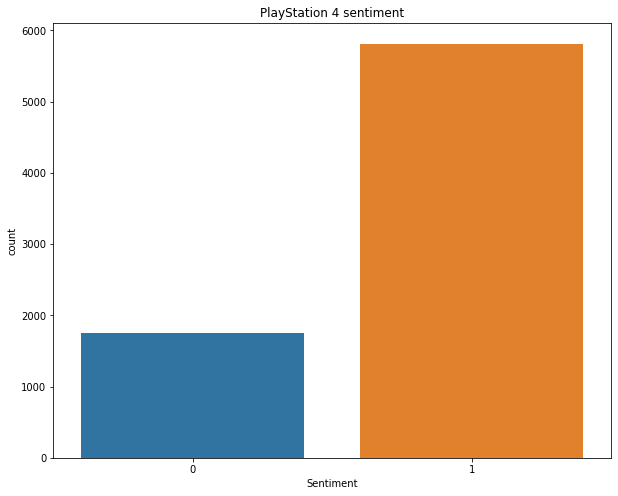

In [ ]:
# Plot sentiment for PlayStation 4

plt.figure(figsize = (10, 8))
sns.countplot(data = df_playstation_text, x = 'Sentiment')
plt.title("PlayStation 4 sentiment")
plt.show()

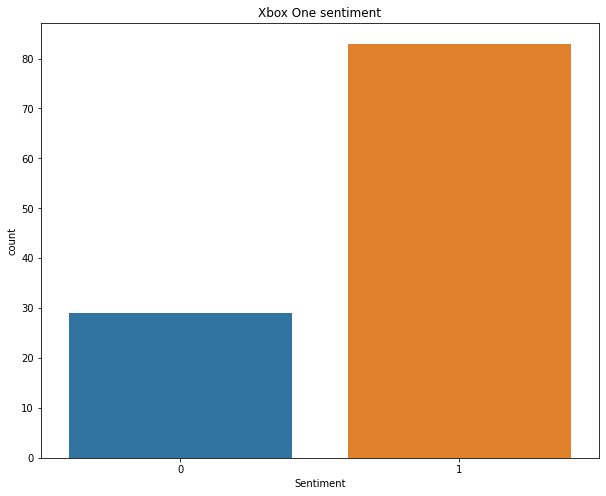

In [ ]:
# Plot sentiment for Xbox One

plt.figure(figsize = (10, 8))
sns.countplot(data = df_xbox_text, x = 'Sentiment')
plt.title("Xbox One sentiment")
plt.show()

In [ ]:
# Create functions to clean the text

# Function to clean text
def clean_text(Review):
  Review = str(Review).lower() # convert to lowercase
  Review = re.sub('\[.*?\]', '', Review)  # Remove special symbols
  Review = re.sub('https?://\S+|www\.\S+', '', Review) # Remove URls
  Review = re.sub('<.*?>+', '', Review) # Remove special symbols
  Review = re.sub(r'[^a-z0-9\s]', '', Review) # Remove punctuation
  Review = re.sub('\n', '', Review) # Remove forced enter
  Review = re.sub('\w*\d\w*', '', Review) # Remove metacharachters
  return Review

# Function to convert list to string
def listToString(s):

  # initialize an empty string
  str1 = " "

  # return string
  return (str1.join(s))

# Function to remove stopwords
def remove_stopword(stop_words, sentence):
    return [word for word in nltk.word_tokenize(sentence) if word not in stop_words]

In [ ]:
# Load standard list of stopwords

stop_words = stopwords.words('english')

# Add own stop words and append to existing ones
stopwords = []
if stopwords is not []:
  stop_words.extend(stopwords)

In [ ]:
# Clean review texts for PlayStation 4


df_playstation_text['review'] = df_playstation_text['reviewText'].apply(clean_text)
df_playstation_text['review'] = df_playstation_text['review'].apply(lambda row: remove_stopword(stop_words, row)).apply(lambda row: listToString(row))

In [ ]:
# Clean review for Xbox One


df_xbox_text['review'] = df_xbox_text['reviewText'].apply(clean_text)
df_xbox_text['review'] = df_xbox_text['review'].apply(lambda row: remove_stopword(stop_words, row)).apply(lambda row: listToString(row))

In [ ]:
# Check how clean reviews look for PlayStation 4 or Xbox

df_playstation_text.head(10)
df_xbox_text.head(10)

,reviewText,overall,Sentiment,review
0,Not everyone will use or need kinect in the be...,5.0,1,everyone use need kinect beginning get lower e...
1,I saw the xbox one in game shop it was amazing...,5.0,1,saw xbox one game shop amazing controller fit ...
2,the mic dont work well in game and some time w...,1.0,0,mic dont work well game time put controller co...
3,Xbox One is awesome.,5.0,1,xbox one awesome
4,It came quickly and works without a hitch. I c...,5.0,1,came quickly works without hitch cant wait get...
5,"Amazing game system, good current lineup of ti...",5.0,1,amazing game system good current lineup titles...
6,I have owned the Xbox one since launch and I l...,5.0,1,owned xbox one since launch love great console...
7,Any one who tells you this controller is good ...,1.0,0,one tells controller good play high level xbox...
8,The Kinect isnt for everyone so this is a grea...,5.0,1,kinect isnt everyone great alternative ignore ...
9,Microsoft will throw you off the game (Live ) ...,2.0,0,microsoft throw game live entire weeks say fol...


In [ ]:
# Create a Data Frame with negative reviews for PlayStation 4

df_playstation_neg = df_playstation_text[df_playstation_text.Sentiment == 0][["review"]].reset_index()

# Create a Data Frame with positive reviews for PlayStation 4


df_playstation_pos = df_playstation_text[df_playstation_text.Sentiment == 1][["review"]].reset_index()


In [ ]:
# Create a Data Frame with negative reviews for Xbox One

df_xbox_neg = df_xbox_text[df_xbox_text.Sentiment == 0][["review"]].reset_index()

# Create a Data Frame with positive reviews for Xbox One

df_xbox_pos = df_xbox_text[df_xbox_text.Sentiment == 1][["review"]].reset_index()


In [ ]:
# Create function, that creates string for a word cloud
def create_string(col):
  string = ''
  for val in col:
    list = nltk.word_tokenize(val)
    for m in list:
      string += " " + m
  return string

In [ ]:
# Create string for a word cloud for negative reviews for PlayStation 4

string_playstation_neg = create_string(df_playstation_neg['review'])

# Create string for a word cloud for positive reviews for PlayStation 4

string_playstation_pos = create_string(df_playstation_pos['review'])

# Create string for a word cloud for negative reviews for Xbox One

string_xbox_neg = create_string(df_xbox_neg['review'])

# Create string for a word cloud for positive reviews for Xbox One

string_xbox_pos = create_string(df_xbox_pos['review'])

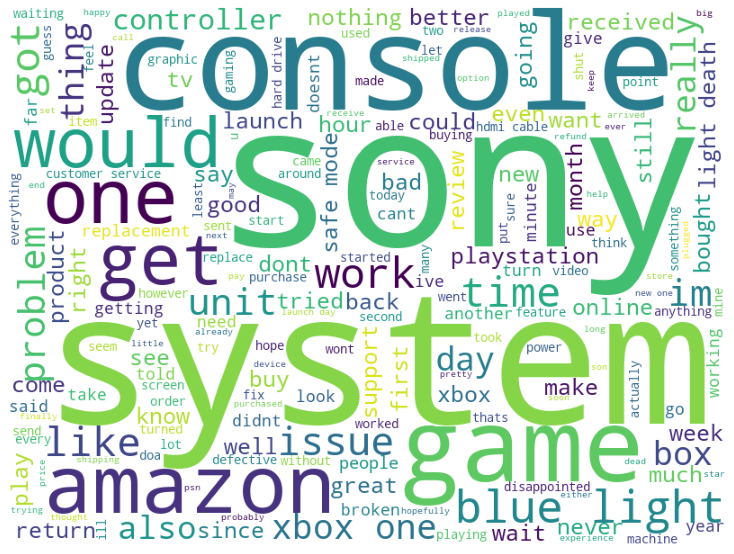

In [ ]:
# Create wordcloud for negative reviews for PlayStation 4

wordcloud_playstation_neg = WordCloud(width = 800, height = 600,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(string_playstation_neg)

# Plot the wordcloud
plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud_playstation_neg)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

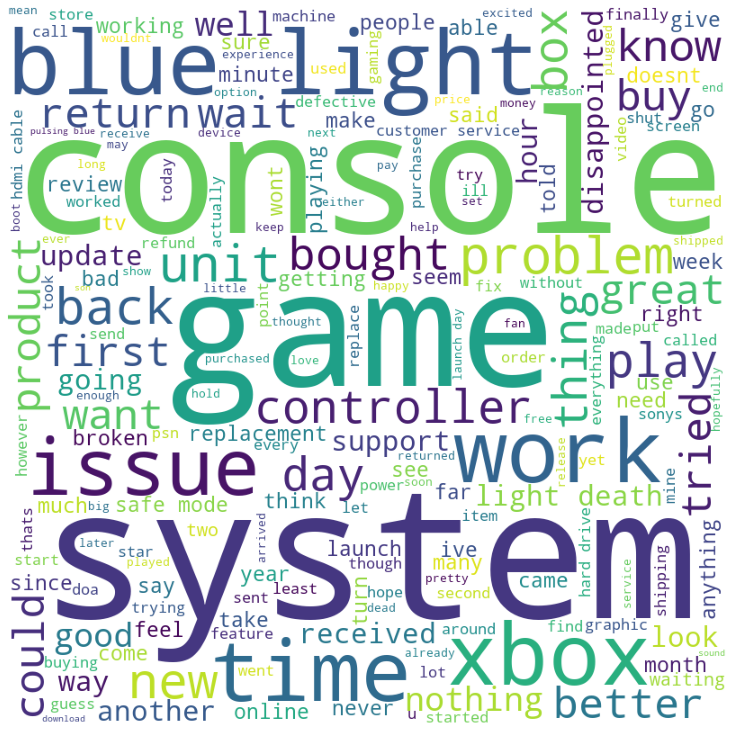

In [ ]:
# Delete frequent meaningless words
stopwords_playstation_negative = ['would', 'get', 'got', 'probably', 'still', 'really', 'sony', 'one','amazon' ,'didnt','cant','even','im', 'playstation', 'like','something', 'also','dont']
df_playstation_neg['review'] = df_playstation_neg['review'].apply(lambda row: remove_stopword(stopwords_playstation_negative, row)).apply(lambda row: listToString(row))

# Create an updated word cloud for playstation negative
string_playstation_neg_2 = create_string(df_playstation_neg["review"])

wordcloud_playstation_neg_2 = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(string_playstation_neg_2)

plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud_playstation_neg_2)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

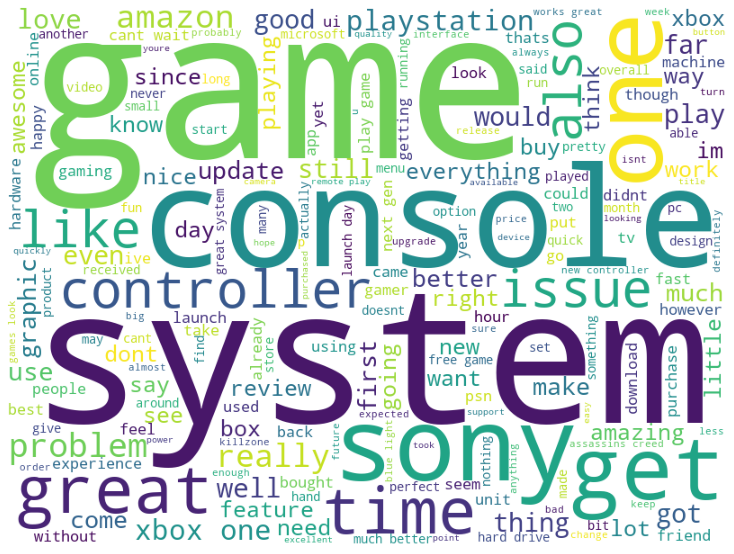

In [ ]:
# Create wordcloud for positive reviews for PlayStation 4

wordcloud_playstation_pos = WordCloud(width = 800, height = 600,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(string_playstation_pos)

# Plot the wordcloud
plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud_playstation_pos)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

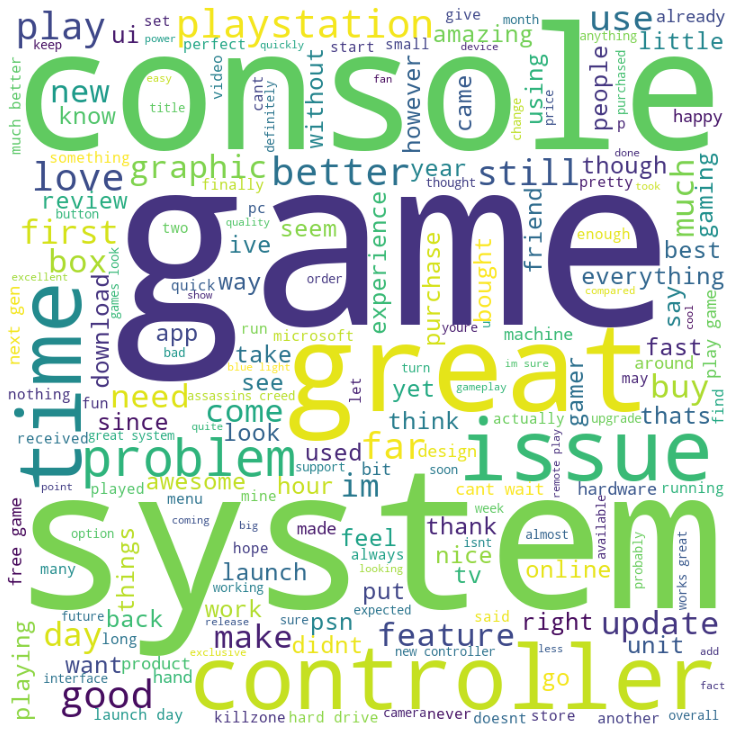

In [ ]:
# Delete frequent meaningless words
stopwords_playstation_positive = ['get', 'sony', 'getting','going','sony', 'one', 'got', 'well', 'really','dont','could','thing','lot','also','able','like','even','xbox','amazon','would']
df_playstation_pos['review'] = df_playstation_pos['review'].apply(lambda row: remove_stopword(stopwords_playstation_positive, row)).apply(lambda row: listToString(row))

# Create an updated word cloud for playstation positive
string_playstation_pos_2 = create_string(df_playstation_pos["review"])

wordcloud_playstation_pos_2 = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(string_playstation_pos_2)

plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud_playstation_pos_2)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

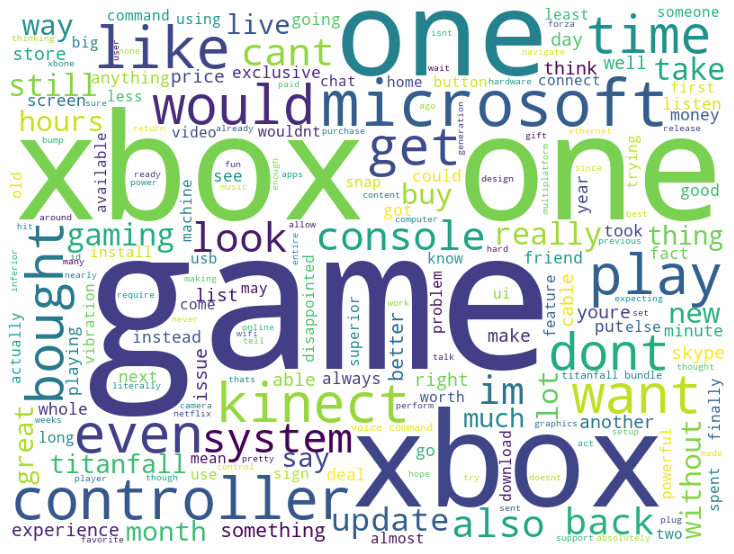

In [ ]:
# Create wordcloud for negative reviews for Xbox One

wordcloud_xbox_neg = WordCloud(width = 800, height = 600,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(string_xbox_neg)


# Plot the wordcloud
plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud_xbox_neg)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

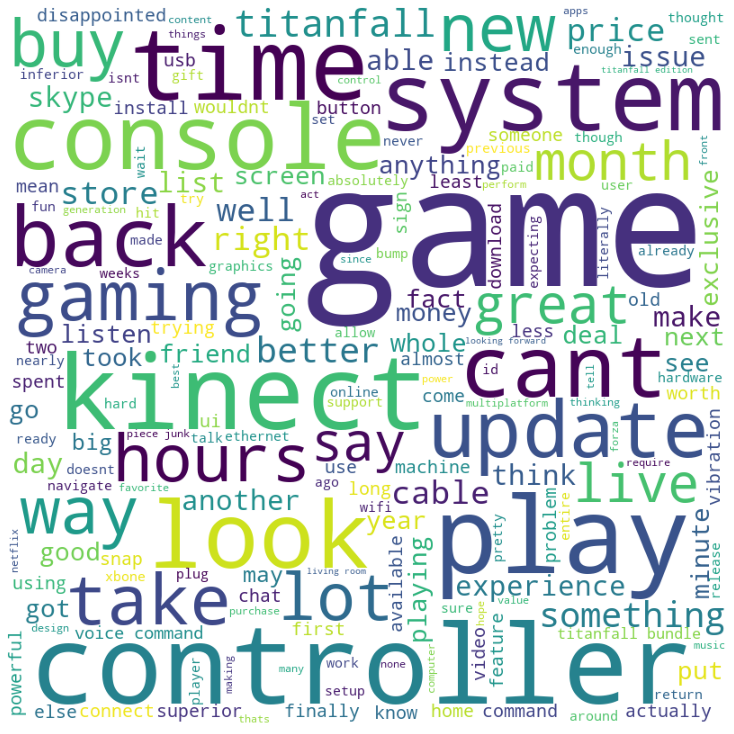

In [ ]:
# Delete frequent meaningless words
stopwords_xbox_negative = ['like','xbox one','xbox','even','dont','want','without','microsoft','get','really','youre','always','thing','one','bought','would','much', 'could', 'also', 'im','still']
df_xbox_neg['review'] = df_xbox_neg['review'].apply(lambda row: remove_stopword(stopwords_xbox_negative, row)).apply(lambda row: listToString(row))

# Create an updated word cloud for xbox negative
string_xbox_neg_2 = create_string(df_xbox_neg["review"])

wordcloud_xbox_neg_2 = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(string_xbox_neg_2)

plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud_xbox_neg_2)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

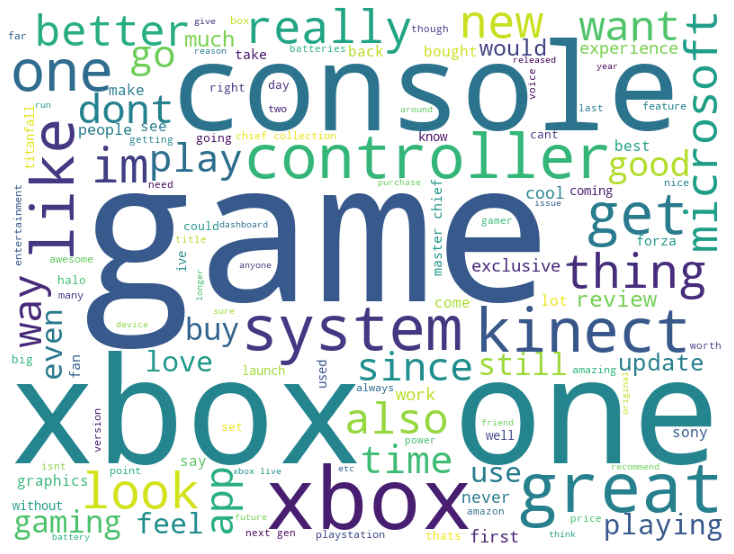

In [ ]:
# Create wordcloud for positive reviews for Xbox One

wordcloud_xbox_pos = WordCloud(width = 800, height = 600,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(string_xbox_pos)

# Plot the wordcloud
plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud_xbox_pos)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

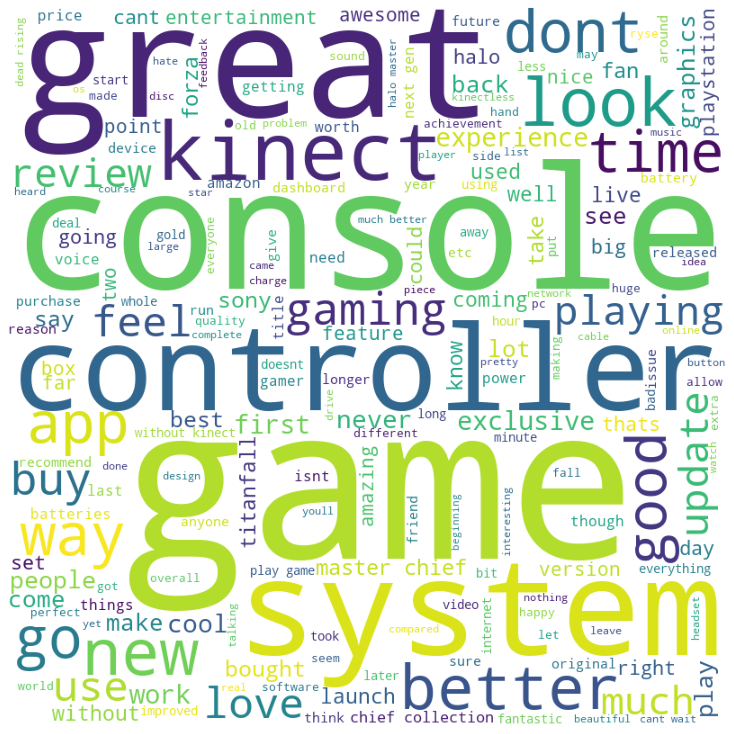

In [ ]:
# Delete frequent meaningless words
stopwords_xbox_positive = ['really', 'xbox one', 'xbox', 'one', 'would', 'since', 'get','microsoft','im','even','also','thing','still', 'want','like','many','always','ive']
df_xbox_pos['review'] = df_xbox_pos['review'].apply(lambda row: remove_stopword(stopwords_xbox_positive, row)).apply(lambda row: listToString(row))

# Create an updated word cloud for xbox positive
string_xbox_pos_2 = create_string(df_xbox_pos["review"])

wordcloud_xbox_pos_2 = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(string_xbox_pos_2)

plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud_xbox_pos_2)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [ ]:
# Create vectors for features and labels for PlayStation 4


X_playstation = df_playstation_text['review']
y_playstation = df_playstation_text['Sentiment']

In [ ]:
# Create vectors for features and labels for Xbox One

X_xbox = df_xbox_text['review']
y_xbox = df_xbox_text['Sentiment']

In [ ]:
# Make a train-test split for PlayStation 4


X_playstation_train, X_playstation_test, y_playstation_train, y_playstation_test = train_test_split(X_playstation, y_playstation, random_state=42, test_size=0.2)


In [ ]:
# Make a train-test split for Xbox One


X_xbox_train, X_xbox_test, y_xbox_train, y_xbox_test = train_test_split(X_xbox, y_xbox, random_state=42, test_size=0.2)

Test accuracy: 0.806
Precision: 0.800
Recall: 0.997
F1 Score: 0.887


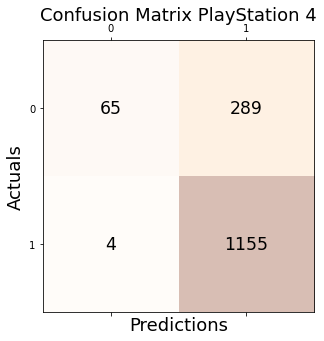

In [ ]:
# Create a pipeline to run a Naive Bayes Classifier for PlayStation 4

clf_playstation = Pipeline([
    ('vect', CountVectorizer(stop_words= "english")),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())])

# Fit train data to the model for PlayStation 4

clf_playstation.fit(X_playstation_train,y_playstation_train)

# Predict results on test data for PlayStation 4

y_playstation_pred = clf_playstation.predict(X_playstation_test)

# Print model metrics for PlayStation 4

print('Test accuracy: %.3f' % accuracy_score(y_playstation_test, y_playstation_pred))
print('Precision: %.3f' % precision_score(y_playstation_test, y_playstation_pred))
print('Recall: %.3f' % recall_score(y_playstation_test, y_playstation_pred))
print('F1 Score: %.3f' % f1_score(y_playstation_test, y_playstation_pred))

# Create a confusion matrix for PlayStation 4 and print it

conf_matrix_playstation = confusion_matrix(y_true=y_playstation_test, y_pred=y_playstation_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_playstation, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_playstation.shape[0]):
    for j in range(conf_matrix_playstation.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_playstation[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix PlayStation 4', fontsize=18)
plt.show()

Test accuracy: 0.826
Precision: 0.826
Recall: 1.000
F1 Score: 0.905


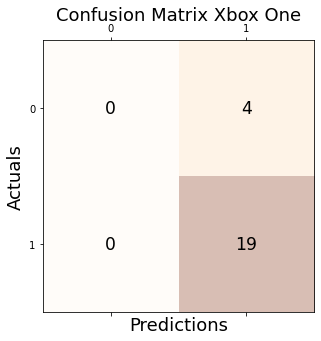

In [ ]:
# Create a pipeline to run a Naive Bayes Classifier for Xbox One
clf_xbox = Pipeline([
    ('vect', CountVectorizer(stop_words= "english")),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())])

# Fit train data to the model for Xbox One

clf_xbox.fit(X_xbox_train,y_xbox_train)

# Predict results on test data for Xbox One

y_xbox_pred = clf_xbox.predict(X_xbox_test)

# Print model metrics for Xbox One


print('Test accuracy: %.3f' % accuracy_score(y_xbox_test, y_xbox_pred))
print('Precision: %.3f' % precision_score(y_xbox_test, y_xbox_pred))
print('Recall: %.3f' % recall_score(y_xbox_test, y_xbox_pred))
print('F1 Score: %.3f' % f1_score(y_xbox_test, y_xbox_pred))

# Create a confusion matrix for Xbox One and print it

conf_matrix_xbox = confusion_matrix(y_true=y_xbox_test, y_pred=y_xbox_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_xbox, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_xbox.shape[0]):
    for j in range(conf_matrix_xbox.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_xbox[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix Xbox One', fontsize=18)
plt.show()
